In [114]:
import ee, geemap
from itertools import product

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()


In [115]:
# pip install folium shapely
import folium
from shapely.geometry import Polygon



okavango = [
    (21.7, -18.2),
    (21.7, -20.3),
    (23.6, -20.3),
    (23.6, -18.2),
]



poly = Polygon(okavango)
# Center map on polygon centroid (lat, lon order for Folium!)
lat, lon = poly.centroid.y, poly.centroid.x
m = folium.Map(location=[lat, lon], zoom_start=7, tiles="CartoDB positron")

# Folium wants [lat, lon] pairs; convert
coords_latlon = [(y, x) for x, y in okavango] + [(okavango[0][1], okavango[0][0])]
folium.Polygon(
    locations=coords_latlon,
    color="red",
    weight=3,
    fill=True,
    fill_opacity=0.2,
    tooltip="Okavango study area",
).add_to(m)

m


### Load Landsat DSWE ImageCollection

In [116]:

def list_image_ids(path: str):
    """
    return IDs of image assets under an Earth Engine path (filters out folders/collections)
    """
    assets = ee.data.listAssets(path).get('assets', [])
    return [a['id'] for a in assets if a.get('type') == 'IMAGE']

def list_ids(path: str):
    """
    return IDs of all assets under an Earth Engine path (filters out folders/collections)
    """
    assets = ee.data.listAssets(path).get('assets', [])
    return [a['id'] for a in assets]


# landsat monthly DSWE
ls_dswe_path = 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products'
ls_dswe_ids  = list_image_ids(ls_dswe_path)
ls_dswe_ids[:10]


['projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_06',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_07',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_09',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_10',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1984_11',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1985_04',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1986_11',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1986_12',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1987_01',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v2/DSWE_Products/DSWE_1987_02']

In [117]:
def load_landsat_dswe(id):
    """
    Load Landsat DSWE image by asset ID, add a binary water mask, and tag date metadata.
    """
    year = ee.String(id).split('_').get(-2)
    month = ee.String(id).split('_').get(-1)
    img = ee.Image(id)
    binary = img.gt(0).toFloat().rename('dswe_bin')
    return img.addBands(binary).set({'year': year, 
            'month': month, 'date': ee.String(year).cat('-').cat(month)})

ls_dswe_collection = ee.ImageCollection([load_landsat_dswe(id) for id in ls_dswe_ids])
print (ls_dswe_collection.first().getInfo()['bands'])

[{'id': 'dswe', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [8320, 7112], 'crs': 'EPSG:4326', 'crs_transform': [0.00026949458523585647, 0, 21.791062667586118, 0, -0.00026949458523585647, -18.269307427723945]}, {'id': 'dswe_bin', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8320, 7112], 'crs': 'EPSG:4326', 'crs_transform': [0.00026949458523585647, 0, 21.791062667586118, 0, -0.00026949458523585647, -18.269307427723945]}]


In [118]:
# Define palettes visualization parameters
palettes = {
    # sequential light→dark blues (ordered magnitudes; ColorBrewer "Blues"-like)
    "dswe_classes": ["white", "#deebf7", "#9ecae1", "#3182bd"],   # 1..4

    # binary white vs blue (crisp on dark/imagery basemaps)
    "dswe_binary":  ["white", "#3182bd"],                         # 0/1

    # zero-centered diverging brown↔teal with light neutral midpoint
    # (good for values around 0: residuals, anomalies, signed ratios)
    "centered":     ["#a6611a", "#dfc27d", "#f5f5f5", "#80cdc1", "#018571"],  # -1..1

    # classic diverging red↔white↔blue
    "diff_rwb":     ["#ef8a62", "#f7f7f7", "#67a9cf"]
}


vis_dswe_classes = {
    "palette": palettes["dswe_classes"],
    "min": 1,
    "max": 4
}

vis_dswe_binary = {
    "palette": palettes["dswe_binary"],
    "min": 0,
    "max": 1
}

vis_centered = {
    "palette": palettes["centered"],
    "min": -1,
    "max": 1
}

vis_diff_rwb = {
    "palette": palettes["diff_rwb"],
    "min": -1,
    "max": 1
}


In [119]:
#   Filters for year-specific and seasonal averages,
# Subset DSWE for comparison to Inman Lyons
#  TODO: check that DSWE and IL years match
dswe_compare = ls_dswe_collection  \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('month', '07')) \
    .filter(ee.Filter.lt('year', '2025')) \

# Compute decade composites for DSWE
dswe_1990s = ls_dswe_collection \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('month',  '07')) \
    .filter(ee.Filter.gte('year', '1985')) \
    .filter(ee.Filter.lte('year', '2005')) \
    .mean()

dswe_2010s = ls_dswe_collection \
    .filter(ee.Filter.gte('month', '07')) \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('year', '2020')) \
    .filter(ee.Filter.lte('year', '2025')) \
    .mean()

dswe_change = dswe_2010s.subtract(dswe_1990s)


In [120]:
# --- export change image export 
run_exports = False

task_change = ee.batch.Export.image.toDrive(
    image=(
        dswe_change
        .select('dswe')                
        .unmask(0)
        .updateMask(dswe_1990s.select('dswe').eq(0))  
        .visualize(**vis_centered)     # use centered scheme for change
    ),
    description='DSWE_change_2010s_vs_1990s',
    folder='Okavango',
    fileNamePrefix='DSWE_change_2010s_vs_1990s',
    region=okavango,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
)

if run_exports:
    task_change.start()
else:
    print("Export created but not started")

Export created but not started


## Load Sentinel DSWE ImageCollection

In [121]:
sent2_dswe_path = 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products'
sent2_dswe_ids  = list_image_ids(sent2_dswe_path)
sent2_dswe_ids[:10]

['projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_12',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_01',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_02',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_03',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_04',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_05',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_06',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_07',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_08',
 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2019_09']

In [122]:
def load_s2_dswe(id):
    """
    Load sentinel DSWE image by asset ID, add a binary water mask, and tag date metadata.
    """    
    year = ee.String(id).split('_').get(-2)
    month = ee.String(id).split('_').get(-1)
    img = ee.Image(id)
    binary = img.gt(0).toFloat().rename('DSWE_bin')
    return img.addBands(binary).set({'year': year, 'month': month, 'date': ee.String(year).cat('-').cat(month)})

s2_dswe = ee.ImageCollection([load_s2_dswe(id) for id in sent2_dswe_ids])
print (s2_dswe.first().getInfo()['properties']['year'])


# Filters to months used in IL 
s2_dswe_compare = s2_dswe \
    .filter(ee.Filter.lte('month', '09')) \
    .filter(ee.Filter.gte('month', '07')) \
    .filter(ee.Filter.lt('year', '2025')) \


# mean DSWE visualization export (10 m)
task_s2_mean = ee.batch.Export.image.toDrive(
    image = s2_dswe_compare.select('DSWE').mean().selfMask().visualize(**vis_dswe_classes),
    description    = 'DSWE_sentinel_mean_JulSep5',
    folder         = 'Okavango',
    fileNamePrefix = 'DSWE_sentinel_mean_JulSep',
    region         = okavango,
    scale          = 10,
    crs            = 'EPSG:4326',
    maxPixels      = 1e13
)



if run_exports:
    task_s2_mean.start()
    print("Started export: DSWE_sentinel_mean_JulSep")
else:
    print("Created export, not started: DSWE_sentinel_mean_JulSep")

2018
Created export, not started: DSWE_sentinel_mean_JulSep


In [123]:
def view_tasks(limit=10):
    """Print the first `limit` Earth Engine tasks with key metadata."""
    ops = ee.data.listOperations()[:limit]
    if not ops:
        print("No tasks found.")
    for i, op in enumerate(ops, 1):
        meta = op.get('metadata', {}) or {}
        state   = meta.get('state', '')
        desc    = meta.get('description', '(no desc)')
        create  = meta.get('createTime', '')
        update  = meta.get('updateTime', '')
        task_id = op.get('name', '')
        print(f"{i:2d}. {state:8}  {desc}")
        print(f"    id: {task_id}")
        print(f"    created: {create} | updated: {update}")


def cancel_tasks(limit=10, states=('READY','RUNNING','PENDING')):
    """Cancel the first `limit` tasks matching given states."""
    for op in ee.data.listOperations()[:limit]:
        meta = op.get('metadata', {}) or {}
        state = meta.get('state', '')
        name  = op.get('name', '')
        desc  = meta.get('description', '(no desc)')
        if state in states:
            ee.data.cancelOperation(name)
            print(f"Canceled: {desc} ({state})")
# see what’s queued
view_tasks(limit=10)

# cancel any READY/RUNNING tasks
# cancel_tasks(limit=5)

 1. SUCCEEDED  my_shape_simplified_2
    id: projects/ee-okavango/operations/NP5PQPO6AWSW54TISSJIW5Q6
    created: 2025-10-06T04:17:27.721192Z | updated: 2025-10-06T04:18:10.577563Z
 2. FAILED    my_shape_export_2
    id: projects/ee-okavango/operations/PZSC7BIFX74OC5AF6IFLSEAT
    created: 2025-10-06T04:12:50.542707Z | updated: 2025-10-06T04:13:14.054545Z
 3. FAILED    my_shape_export_2
    id: projects/ee-okavango/operations/TUO5FEOJFFV2MGUQ3QDNWHW7
    created: 2025-10-06T04:10:59.276342Z | updated: 2025-10-06T04:11:23.341158Z
 4. SUCCEEDED  my_shape_export
    id: projects/ee-okavango/operations/4ZIQC3DJJKWGFFFI57JDPZOJ
    created: 2025-10-06T03:51:32.223153Z | updated: 2025-10-06T03:51:42.770585Z
 5. SUCCEEDED  AOI5_bermdata_20251005
    id: projects/ee-okavango/operations/AZR6BPSYCHJE3HGR6SKKSJVV
    created: 2025-10-06T00:25:16.919164Z | updated: 2025-10-06T00:39:36.335230Z
 6. SUCCEEDED  AOI4_bermdata_20251005
    id: projects/ee-okavango/operations/QJHGOBWIY7ICGK24BKEJ3SRG
  

In [124]:
def explain_task(task_id=None):
    """
    Print details (state, description, error) for a given task_id,
    or for the most recent FAILED task if task_id is None.
    """
    ops = ee.data.listOperations()
    if not ops:
        print("No tasks found."); return

    if task_id:
        op = next((o for o in ops if o.get('name') == task_id), None)
        print (len(op))
        if not op:
            print(f"No task with id {task_id}"); 
            return
    else:
        failed = [o for o in ops if o.get('metadata', {}).get('state') == 'FAILED']
        if not failed:
            print("No failed tasks."); return
        op = max(failed, key=lambda o: o.get('metadata', {}).get('updateTime',''))
#         print (op['error']['message'], len(op))

    meta = op.get('metadata', {}) or {}
    err  = op.get('error', {})
    msg  = err.get('message') if isinstance(err, dict) else err

    print(f"desc   : {meta.get('description','(no desc)')}")
    print(f"id     : {op.get('name')}")
    print(f"state  : {meta.get('state')}")
    print(f"error  : {msg}")

explain_task()




desc   : my_shape_export_2
id     : projects/ee-okavango/operations/PZSC7BIFX74OC5AF6IFLSEAT
state  : FAILED
error  : Encoded string is too large


## Inman Lyons layers


 Inman and Lyons (2020) created their landcover/inundation maps using annual 
 Landsat composites from  July through September, the peak inundation period in
 the Okavango Delta.

 Composites are the median of all cloud/shadow-masked scenes in that window, 
 and gap-fill from ±1 year. Years with large gaps were dropped 
 (1993, 2000, 2009, 2010, 2012).
 For validation imagery, they inspected high-resolution images July–October 
 (broader than the composites) alongside the Landsat true-color composites.


In [125]:
def load_il_image(aid, band_name=None):
    """Load one Inman–Lyons image by asset id; optionally rename first band; tag 'year'."""
    img = ee.Image(aid)
    if band_name:
        img = img.select(0).rename(band_name)
    year = ee.String(aid).split('_').get(-1)
    return img.set({'year': year})

def load_il(path, band_name=None):
    """Load all IMAGE assets under a folder into an ImageCollection (client-side list)."""
    assets = ee.data.listAssets(path).get('assets', [])
    ids = [a['id'] for a in assets if a.get('type') == 'IMAGE']
    images = [load_il_image(i, band_name) for i in ids]  # build a Python list of ee.Image
    return ee.ImageCollection(images)


# --- IL collections ---
IL_collection = load_il('projects/ee-okavango/assets/Inman_Lyons/FloodArea')
IL_og         = load_il('projects/ee-okavango/assets/Inman_Lyons/Annual_inundation_maps',
                        band_name='SR_B7')
# prefer IL_og through 2018, then FloodArea
IL_merged     = IL_og.filter(ee.Filter.lt('year', '2019')).merge(IL_collection)  

# --- means & diffs (single-summary exports) ---
IL_mean      = IL_merged.mean()  # multi-year mean IL inundation
IL_mean_diff = IL_mean.subtract(dswe_compare.select('dswe_bin').mean()).rename('IL_minus_DSWE_mean')  # mean IL - mean DSWE


In [126]:
# # --- region (already have this above, included here for completeness) ---
okavango_rectangle = ee.Geometry.Polygon(
    [[[21.6, -18.2],
      [21.6, -20.],
      [24.1, -20.],
      [24.1, -18.2],
      [21.6, -18.2]]],
    None, False
)

okavango_fc = ee.FeatureCollection('projects/ee-okavango/assets/shapes/okavango_outline_20241031');

okavango_feat = ee.Feature(okavango_fc.first());
okavango = okavango_fc.geometry();


# 1) Load shapefile as EE FeatureCollection
shp_path = "../data/Delta_UCB_WGS84/Delta_UCB_WGS84.shp"  # <-- update
okavango_fc = geemap.shp_to_ee(shp_path)     # ee.FeatureCollection

# 2) Make a single, clean polygon geometry (union + buffer(0))
okavango = (okavango_fc
            .geometry()
            .dissolve(maxError=100)          
           )



In [127]:
# --- helper to add (date, count) properties to each image ---
def add_pixel_count(img):
    # count pixels with dswe_bin == 1 (i.e., DSWE > 0)
    count = (img.select('dswe_bin')
               .reduceRegion(ee.Reducer.sum(), okavango, scale=30, maxPixels=1e13)
               .get('dswe_bin'))

    # build a date from 'year' and 'month' image properties
    year  = ee.Number.parse(img.get('year'))
    month = ee.Number.parse(img.get('month'))  # '01'..'12' → number
    date  = ee.Date.fromYMD(year, month, 1)

    return img.set({'count': count, 'date': date.millis()})

# --- build the time series on the server ---
ts_ic = (ls_dswe_collection
         .sort('year')      # 'YYYY' strings are fine for lexicographic sort
         .sort('month')     # '01'..'12'
         .map(add_pixel_count))

# Option A: bring back as two arrays and print a small table (quick look)
dates_millis = ts_ic.aggregate_array('date').getInfo()
counts       = ts_ic.aggregate_array('count').getInfo()

from datetime import datetime, timezone
rows = []
for d, c in zip(dates_millis, counts):
    dt = datetime.fromtimestamp(d/1000, tz=timezone.utc).strftime('%Y-%m')
    rows.append((dt, int(c) if c is not None else None))

print("YYYY-MM, pixel_count_dswe_gt0")
for r in rows:
    print(*r, sep=", ")

# Convert to a FeatureCollection with date/count properties and export.
ts_fc = ee.FeatureCollection(
    ts_ic.map(lambda im: ee.Feature(None, {
        'date': ee.Date(ee.Number(im.get('date'))).format('YYYY-MM'),
        'count': im.get('count')
    }))
)

if run_exports:
    ee.batch.Export.table.toDrive(
        collection=ts_fc,
        description='landsat_dswe_monthly_count',
        folder='Okavango',
        fileNamePrefix='landsat_dswe_monthly_count',
        fileFormat='CSV'
    ).start()


YYYY-MM, pixel_count_dswe_gt0
1987-01, 3590227
1989-01, 6173610
1991-01, 3347874
1992-01, 3198614
1993-01, 2368296
1994-01, 3177007
1995-01, 1368397
1996-01, 1751145
1997-01, 2736909
1998-01, 2164589
1999-01, 2338436
2000-01, 3225111
2001-01, 1567792
2002-01, 2939366
2003-01, 1643972
2007-01, 3353932
2010-01, 5693972
2011-01, 2446976
2014-01, 4225915
2015-01, 2559390
2016-01, 1408849
2017-01, 3975163
2018-01, 1213328
2019-01, 1326124
2020-01, 1058538
2021-01, 5069770
2022-01, 1667237
2023-01, 1104677
2024-01, 1512132
2025-01, 3744692
1987-02, 3681920
1989-02, 7382628
1990-02, 2831342
1991-02, 5420411
1992-02, 3204311
1993-02, 3466769
1995-02, 2005215
1996-02, 2139450
1997-02, 2739437
1998-02, 1933180
1999-02, 2823491
2000-02, 4403196
2001-02, 2766701
2002-02, 2370852
2003-02, 2180912
2004-02, 5109829
2005-02, 3785556
2006-02, 6576569
2007-02, 4014114
2008-02, 6166615
2010-02, 6122111
2011-02, 2635811
2014-02, 4534574
2015-02, 2768343
2016-02, 1759465
2017-02, 6028031
2018-02, 1626048
2

In [128]:
import pandas as pd

def fc_to_dataframe(fc, props=('date','count'), limit=None):
    """
    Convert an ee.FeatureCollection to a pandas DataFrame.
    NOTE: Uses getInfo(); fine for small/medium tables.
    """
    fc_q = fc if limit is None else fc.limit(int(limit))
    info = fc_q.getInfo()
    rows = [{k: f['properties'].get(k) for k in props} for f in info['features']]
    df = pd.DataFrame(rows)
    # parse 'date' like 'YYYY-MM' if present
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m', errors='coerce')
    return df

df_ls = fc_to_dataframe(ts_fc, props=('date','count'))
print(df_ls.head())


        date         count
0 1987-01-01  3.590227e+06
1 1989-01-01  6.173610e+06
2 1991-01-01  3.347874e+06
3 1992-01-01  3.198615e+06
4 1993-01-01  2.368296e+06


In [129]:
# --- Sentinel-2 DSWE monthly pixel-count time series (DSWE > 0) ---

# Helper to attach (date, count) to each Sentinel-2 image
def add_pixel_count_s2(img):
    # If no DSWE_bin, use: gt0 = img.select('dswe').gt(0)
    gt0 = img.select('DSWE_bin')
    count = gt0.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=okavango,
        scale=10,
        maxPixels=1e13
    ).get(gt0.bandNames().get(0))  # fetch the band key safely

    year  = ee.Number.parse(img.get('year'))
    month = ee.Number.parse(img.get('month'))
    date  = ee.Date.fromYMD(year, month, 1)
    return img.set({'count': count, 'date': date.format('YYYY-MM')})

# Build the time series (server-side), sorted by year then month
ts_ic_s2 = (s2_dswe
            .sort('year')
            .sort('month')
            .map(add_pixel_count_s2))

# Convert to a FeatureCollection of {date, count}
ts_fc_s2 = ee.FeatureCollection(
    ts_ic_s2.map(lambda im: ee.Feature(None, {
        'date': im.get('date'),
        'count': im.get('count')
    }))
)

# ---- Pandas DataFrame (array-based, lightweight fetch) ----
import pandas as pd

dates_s2  = ts_fc_s2.aggregate_array('date').getInfo()
counts_s2 = ts_fc_s2.aggregate_array('count').getInfo()

df_s2 = pd.DataFrame({'date': dates_s2, 'count': counts_s2})
df_s2['date'] = pd.to_datetime(df_s2['date'], format='%Y-%m', errors='coerce')

print(df_s2.head())


        date         count
0 2019-01-01  6.776887e+06
1 2020-01-01  7.922782e+06
2 2021-01-01  3.135053e+07
3 2022-01-01  1.742858e+07
4 2023-01-01  6.067235e+06


In [130]:
# --- Inman & Lyons monthly pixel-count time series (values > 0) ---

IL_merged = IL_og.filter(ee.Filter.lte('year', '2019')).merge(IL_collection)
print (IL_merged.size().getInfo())
# keep IL_og only through 2019
il_og_pre2019 = IL_og.filter(ee.Filter.lte('year', '2019'))

# list of years already covered (as strings, distinct)
years_in_og = il_og_pre2019.aggregate_array('year').distinct()

# keep only those images in IL_Collection whose 'year' is not in years_in_og
# (ee.Filter.inList(...).Not() excludes matching years)
il_coll_missing_years = IL_collection.filter(
    ee.Filter.inList('year', years_in_og).Not()
)

# merge: first collection + only-missing-years from second
IL_merged = il_og_pre2019.merge(il_coll_missing_years)
print (IL_merged.size().getInfo())

43
30


In [1]:

# Helper: attach (date, count) for each IL image
def add_pixel_count_il(img):
    # Use the first band (IL products can have varying names); rename for consistency
    il = img.select(0).rename('il')
    gt0 = il.eq(1)  # treat >0 as inundated

    count = gt0.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=okavango,
        scale=30,          # IL maps are Landsat-derived (30 m)
        maxPixels=1e13
    ).get('il')

    # Build a date from the 'year' property; IL images are annual composites
    year = ee.Number.parse(img.get('year'))
    date = ee.Date.fromYMD(year, 1, 1)  # use Jan 1 of that year for a consistent timestamp

    return img.set({'count': count, 'date': date.format('YYYY-MM')})

# Build time series (sorted by year for readability)
ts_ic_il = (IL_merged
            .sort('year')
            .map(add_pixel_count_il))

# To FeatureCollection of {date, count}
ts_fc_il = ee.FeatureCollection(
    ts_ic_il.map(lambda im: ee.Feature(None, {
        'date': im.get('date'),
        'count': im.get('count')
    }))
)

# ---- Pandas DataFrame (array-based fetch) ----
import pandas as pd

dates_il  = ts_fc_il.aggregate_array('date').getInfo()
counts_il = ts_fc_il.aggregate_array('count').getInfo()

df_il = pd.DataFrame({'date': dates_il, 'count': counts_il})
df_il['date'] = pd.to_datetime(df_il['date'], format='%Y-%m', errors='coerce')

print(df_il.head())


NameError: name 'IL_merged' is not defined

In [132]:
img = IL_collection.first()  # or a specific year image
hist = img.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=okavango,
    scale=30,
    maxPixels=1e13
)
print(hist.getInfo())  # inspect keys 0,1,2,3 and their counts
print(img.bandNames().getInfo())

{'SR_B7': {'0': 19672677.729411766, '1': 4923978.313725491}}
['SR_B7']


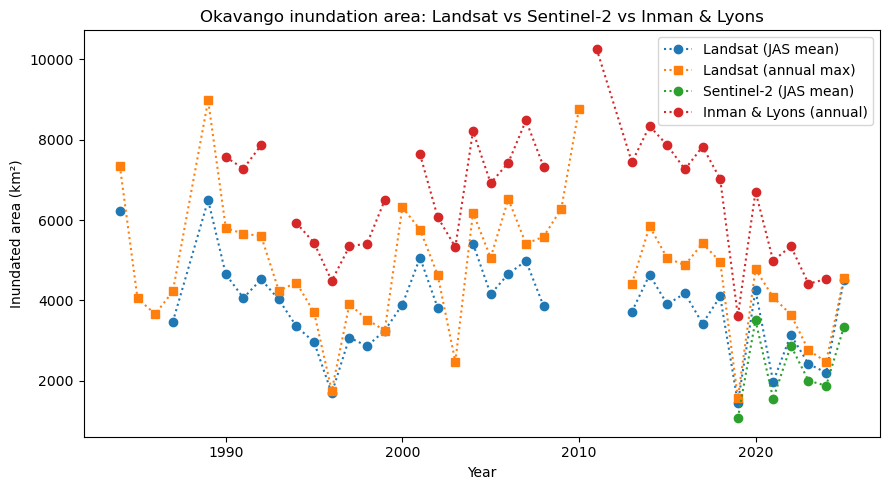

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

PX30_TO_KM2 = 0.0009  # 30 m pixel area in km²

def jas_annual_mean(df: pd.DataFrame, label: str, value_col: str = 'area_km2'):
    """Return ['year', f'{label}_jas_mean_km2'] as July–September mean of `value_col`."""
    out = df.copy()
    out['date']  = pd.to_datetime(out['date'], errors='coerce')
    out['year']  = out['date'].dt.year
    out['month'] = out['date'].dt.month
    out = out[out['month'].isin([7, 8, 9])]
    ann = (out.groupby('year', as_index=False)[value_col]
              .mean()
              .rename(columns={value_col: f'{label}_jas_mean_km2'}))
    return ann

def annual_max(df: pd.DataFrame, label: str, value_col: str = 'area_km2'):
    """Return ['year', f'{label}_jas_mean_km2'] as July–September mean of `value_col`."""
    out = df.copy()
    out['date']  = pd.to_datetime(out['date'], errors='coerce')
    out['year']  = out['date'].dt.year
    out['month'] = out['date'].dt.month
    out = out[out['month'].isin([4,5,6,7, 8, 9, 10,11, 12])]
    ann = (out.groupby('year', as_index=False)[value_col]
              .max()
              .rename(columns={value_col: f'{label}_max_km2'}))
    return ann

# 1) Landsat: pixels -> km²
df_ls_km2 = df_ls.copy()
df_ls_km2['area_km2'] = df_ls_km2['count'] * PX30_TO_KM2
ls_ann = jas_annual_mean(df_ls_km2, label='landsat')

ls_max = annual_max(df_ls_km2, label='landsat')


# 2) Sentinel-2: convert to 30 m-pixel equivalents (÷9), then -> km²
df_s2_km2 = df_s2.copy()
df_s2_km2['area_km2'] = (df_s2_km2['count'] / 9.0) * PX30_TO_KM2
s2_ann = jas_annual_mean(df_s2_km2, label='sentinel')

# 3) Inman & Lyons (30 m): pixels -> km², then annual mean (already annual timestamps)
df_il_km2 = df_il.copy()
df_il_km2['date'] = pd.to_datetime(df_il_km2['date'], errors='coerce')
df_il_km2['year'] = df_il_km2['date'].dt.year
il_ann = (df_il_km2.assign(area_km2=df_il_km2['count'] * PX30_TO_KM2)
                    .groupby('year', as_index=False)['area_km2']
                    .mean()
                    .rename(columns={'area_km2': 'il_annual_km2'}))

# Combine and plot
annual_km2 = (ls_ann.merge(ls_max, on='year', how='outer')
                    .merge(s2_ann, on='year', how='outer')
                    .merge(il_ann, on='year', how='outer')
                    .sort_values('year')
                    .reset_index(drop=True))

plt.figure(figsize=(9, 5))
plt.plot(annual_km2['year'], annual_km2['landsat_jas_mean_km2'], marker='o', linestyle = ":", label='Landsat (JAS mean)')
plt.plot(annual_km2['year'], annual_km2['landsat_max_km2'], marker='s', linestyle = ":", label='Landsat (annual max)')
plt.plot(annual_km2['year'], annual_km2['sentinel_jas_mean_km2'], marker='o', linestyle = ":", label='Sentinel-2 (JAS mean)')
plt.plot(annual_km2['year'], annual_km2['il_annual_km2'],        marker='o', linestyle = ":", label='Inman & Lyons (annual)')
plt.xlabel('Year'); plt.ylabel('Inundated area (km²)')
plt.title('Okavango inundation area: Landsat vs Sentinel-2 vs Inman & Lyons')
plt.legend(); plt.tight_layout(); plt.show()


In [134]:
annual_km2.corr().round(2)['il_annual_km2']

year                    -0.13
landsat_jas_mean_km2     0.91
landsat_max_km2          0.90
sentinel_jas_mean_km2    0.92
il_annual_km2            1.00
Name: il_annual_km2, dtype: float64

In [227]:
# annual_km2.to_csv("annual_flood_area_km2.csv")

In [245]:
from pathlib import Path
import xarray as xr
import rioxarray  # ensures .rio accessor
import geopandas as gpd
from shapely.geometry import mapping
import ee, json

# Load + dissolve the asset to a single geometry
fc = ee.FeatureCollection("projects/ee-okavango/assets/shapes/okavango_outline_20241031")
geom_ee = ee.Geometry(fc.geometry())                 # dissolve to one
geom_geojson = geom_ee.getInfo()                     # GeoJSON-like dict
geom = mapping(shape(geom_geojson))                  # shapely mapping (lon/lat)


CROPS_DIR = Path("cygnss_okavango_full/crops_nc")      # your existing monthly crops
CLIPPED_DIR = Path("cygnss_okavango_full/crops_nc_clip")
CLIPPED_DIR.mkdir(parents=True, exist_ok=True)

# Load polygon (assumed EPSG:4326 lon/lat)
# gdf = gpd.read_file("okavango_outline_20241031.geojson")
# geom = mapping(gdf.to_crs("EPSG:4326").unary_union)  

def clip_nc(in_path: Path, out_path: Path):
    ds = xr.open_dataset(in_path, decode_times=False)

    # tell rioxarray which dims are spatial + CRS
    ds = ds.rio.write_crs("EPSG:4326")\
             .rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

    # clip each data variable that has lat/lon dims
    clipped_vars = []
    for v in ds.data_vars:
        dv = ds[v]
        if "lat" in dv.dims and "lon" in dv.dims:
            cv = dv.rio.clip([geom], crs="EPSG:4326", drop=True)
            clipped_vars.append(cv.to_dataset(name=v))
        else:
            # non-spatial vars pass through unchanged
            clipped_vars.append(dv.to_dataset(name=v))

    ds_clip = xr.merge(clipped_vars)

    # light compression
    enc = {v: {"zlib": True, "complevel": 4} for v in ds_clip.data_vars}
    ds_clip.to_netcdf(out_path, encoding=enc)
    ds.close()

# batch
for p in sorted(CROPS_DIR.glob("okav_*.nc")):
    out = CLIPPED_DIR / p.name.replace(".nc", ".nc")
    clip_nc(p, out)
    #print("Wrote", out)


Wrote cygnss_okavango_full/crops_nc_clip/okav_2018-08.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2018-09.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2018-10.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2018-11.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2018-12.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-01.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-02.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-03.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-04.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-05.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-06.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-07.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-08.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-09.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-10.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-11.nc
Wrote cygnss_okavango_full/crops_nc_clip/okav_2019-12.nc
Wrote cygnss_okavango_full/crop

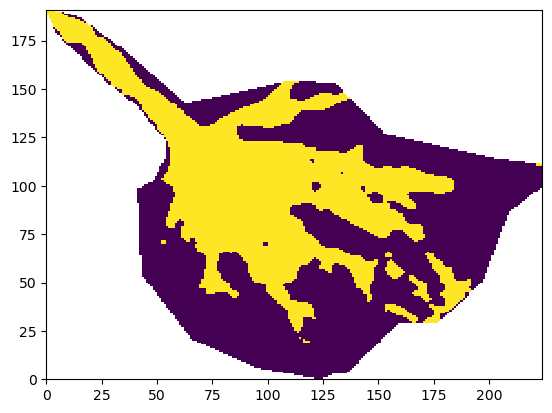

In [249]:
# ds = xr.open_dataset('cygnss_okavango_full/crops_nc/okav_2025-07.nc', decode_times=False)
# plt.imshow(ds['watermask'])

ds = xr.open_dataset('cygnss_okavango_full/crops_nc_clip/okav_2025-07.nc', decode_times=False)
plt.pcolormesh(ds['watermask'])

In [ ]:
import re
from pathlib import Path
from typing import Optional, Tuple, List

import xarray as xr
import numpy as np
import pandas as pd

EARTH_RADIUS_M = 6_371_008.8  # meters

def _timestamp_from_filename(path: Path) -> pd.Timestamp:
    m = re.search(r"(\d{4})-(\d{2})", path.name)
    if not m:
        raise ValueError(f"Filename must contain YYYY-MM: {path.name}")
    y, mo = int(m.group(1)), int(m.group(2))
    return pd.Timestamp(year=y, month=mo, day=1)

def _cell_area_km2(lat_1d: np.ndarray, dlat_deg: float, dlon_deg: float) -> np.ndarray:
    dlat = np.deg2rad(dlat_deg)
    dlon = np.deg2rad(dlon_deg)
    area_m2 = (EARTH_RADIUS_M**2) * dlat * dlon * np.cos(np.deg2rad(lat_1d))
    return 1 #area_m2 / 1e6  # km²

def monthly_inundation_df(
    crops_dir: str | Path,
    varname: Optional[str] = None,
    threshold: float = 0.5,) -> pd.DataFrame:
    """
    Compute total inundation area (km²) per month from okav_YYYY-MM.nc files.
    Assumes coordinates are named 'lat' and 'lon' and grid is regular.
    """
    crops_dir = Path(crops_dir)
    paths = sorted(crops_dir.glob("okav_*.nc"), key=lambda p: p.name)
    if not paths:
        raise FileNotFoundError(f"No okav_*.nc files found in {crops_dir}")

    rows: List[dict] = []

    for p in paths:
        ts = _timestamp_from_filename(p)

        ds = xr.open_dataset(p, decode_times=False)

        lat = ds["lat"].values
        lon = ds["lon"].values

        # pick variable
        if varname is None:
            # prefer something with "mask"/"water" in the name, else first data_var
            cand = [v for v in ds.data_vars if ("mask" in v.lower()) or ("water" in v.lower())]
            vname = cand[0] if cand else list(ds.data_vars)[0]
        else:
            vname = varname

        da = ds[vname]
        # if a time dim exists, take the first slice (monthly product)
        tdim = next((d for d in da.dims if d.lower().startswith("time")), None)
        if tdim is not None:
            da = da.isel({tdim: 0}).squeeze(drop=True)

        # ensure 1D lat/lon
        if lat.ndim != 1: lat = np.unique(lat)
        if lon.ndim != 1: lon = np.unique(lon)

        # grid spacing (deg) — assume regular grid
        dlat = float(np.abs(lat[1] - lat[0]))
        dlon = float(np.abs(lon[1] - lon[0]))

        # per-row cell area (km²), broadcast to full grid
        row_area = _cell_area_km2(lat, dlat, dlon)  # (nlat,)
        area_grid = np.repeat(row_area[:, None], len(lon), axis=1)  # (lat, lon)

        arr = np.asarray(da)
        mask = np.isfinite(arr) & (arr >= threshold)
        water_km2 = float((area_grid * mask).sum())

        rows.append({"date": ts, "km2": water_km2})
        ds.close()

    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    return df

df_monthly = monthly_inundation_df("cygnss_okavango_full/crops_nc_clip", threshold=0.5)
# Annual peak flood extent:
df_annual_max = df_monthly.groupby("year", as_index=False)["km2"].max().rename(columns={"km2":"annual_max_km2"})

df_jas_mean = df_monthly.query('month in [7,8,9]').groupby("year", as_index=False)["km2"].max().rename(columns={"km2":"annual_max_km2"})


Missing months (Landsat): ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10'] … total 92
Missing months (Sentinel): ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10'] … total 92


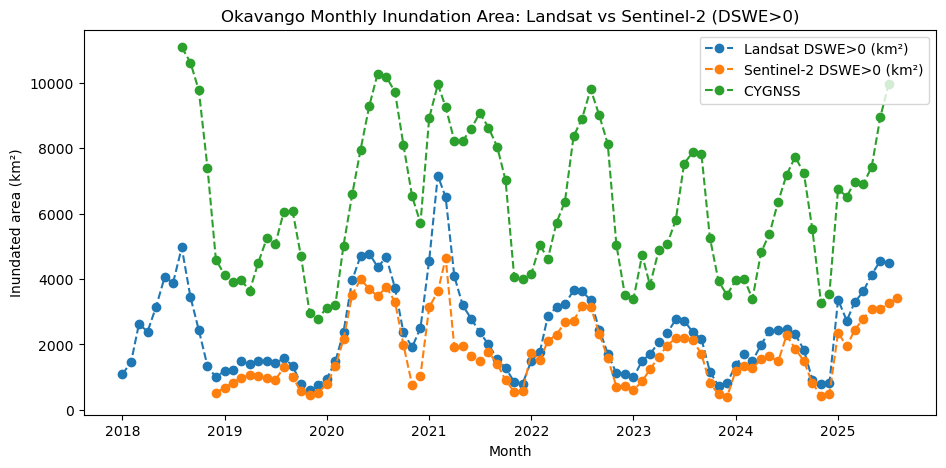

In [257]:

PX30_TO_KM2 = 0.0009  # 30 m pixel area in km²

def prep_monthly(df: pd.DataFrame, sensor: str):
    """
    From a monthly df with ['date','count'], return a monthly series in km²:
      - Landsat: count * 0.0009
      - Sentinel-2: (count / 9) * 0.0009
    Aggregates by month (mean if multiple rows per month).
    """
    out = df[['date','count']].copy()
    out['date'] = pd.to_datetime(out['date'], errors='coerce')
    out = out.dropna(subset=['date'])
    out['month'] = out['date'].dt.to_period('M').dt.to_timestamp()
    out['year'] = out['date'].dt.to_period('Y').dt.to_timestamp()    

    if sensor == 'landsat':
        out['km2'] = out['count'] * PX30_TO_KM2
    elif sensor == 'sentinel':
        out['km2'] = (out['count'] / 9.0) * PX30_TO_KM2
    else:
        raise ValueError("sensor must be 'landsat' or 'sentinel'")

    # average if multiple entries in a month
    return (out.groupby('month', as_index=True)[['km2','year']]
               .mean()
               .sort_index())

# Build monthly series
ls_monthly = prep_monthly(df_ls, sensor='landsat').query('year > 2017')
s2_monthly = prep_monthly(df_s2, sensor='sentinel')

# Create a complete monthly index spanning both series
start = min(ls_monthly.index.min(), s2_monthly.index.min())
end   = max(ls_monthly.index.max(), s2_monthly.index.max())
full_months = pd.date_range(start=start, end=end, freq='MS')  # month starts

ls_full = ls_monthly.reindex(full_months)
s2_full = s2_monthly.reindex(full_months)

# list missing months (where either is NaN)
missing_ls = ls_full[ls_full.isna()].index.strftime('%Y-%m').tolist()
missing_s2 = s2_full[s2_full.isna()].index.strftime('%Y-%m').tolist()
print("Missing months (Landsat):", missing_ls[:10], "… total", len(missing_ls))
print("Missing months (Sentinel):", missing_s2[:10], "… total", len(missing_s2))

# Plot monthly DSWE area (km²), dashed lines with markers
plt.figure(figsize=(11, 5))
plt.plot(ls_full.index, ls_full['km2'], marker='o', linestyle='--', label='Landsat DSWE>0 (km²)')
plt.plot(s2_full.index, s2_full['km2'], marker='o', linestyle='--', label='Sentinel-2 DSWE>0 (km²)')
plt.xlabel('Month')
plt.ylabel('Inundated area (km²)')
plt.title('Okavango Monthly Inundation Area: Landsat vs Sentinel-2 (DSWE>0)')
plt.plot(df_monthly['date'], df_monthly['km2'], marker='o', linestyle='--', label='CYGNSS ')
plt.legend()



In [252]:
df_annual_max


year  annual_max_km2
0  2018    11081.272461
1  2019     6082.127930
2  2020    10276.968750
3  2021     9947.825195
4  2022     9799.390625
5  2023     7873.000488
6  2024     7732.585449
7  2025     9966.142578

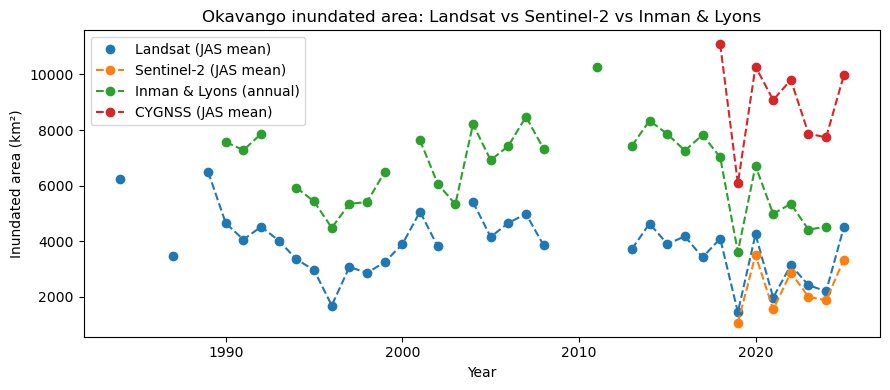

In [254]:
# Pick a clear, color-blind friendly palette
COLORS = {
    'Landsat (JAS mean)':        'C0',
    'Sentinel-2 (JAS mean)':     'C1',
    'Inman & Lyons (annual)':    'C2',
    'CYGNSS':    'C3',    
}

def plot_gapped(years, values, label, marker='o', linestyle='--', color=None):
    years = list(years); values = list(values)
    seg_x, seg_y, prev_year, segments = [], [], None, []

    for y, v in zip(years, values):
        if pd.isna(v):
            if seg_x: segments.append((seg_x, seg_y))
            seg_x, seg_y, prev_year = [], [], None
            continue
        if prev_year is None or y != prev_year + 1:
            if seg_x: segments.append((seg_x, seg_y))
            seg_x, seg_y = [y], [v]
        else:
            seg_x.append(y); seg_y.append(v)
        prev_year = y
    if seg_x: segments.append((seg_x, seg_y))

    for x, y in segments:
        if len(x) == 1:
            plt.plot(x, y, marker=marker, linestyle='none', color=color, label=label)
        else:
            plt.plot(x, y, marker=marker, linestyle=linestyle, color=color, label=label)
        label = None  # avoid duplicate legend entries

plt.figure(figsize=(9, 4))
plot_gapped(annual_km2['year'], annual_km2['landsat_jas_mean_km2'],
            'Landsat (JAS mean)',        color=COLORS['Landsat (JAS mean)'])
plot_gapped(annual_km2['year'], annual_km2['sentinel_jas_mean_km2'],
            'Sentinel-2 (JAS mean)',  color=COLORS['Sentinel-2 (JAS mean)'])
plot_gapped(annual_km2['year'], annual_km2['il_annual_km2'],
            'Inman & Lyons (annual)',    color=COLORS['Inman & Lyons (annual)'])

plot_gapped(df_jas_mean['year'], df_jas_mean['annual_max_km2'],
            'CYGNSS (JAS mean)',    color=COLORS['CYGNSS'])

plt.xlabel('Year'); plt.ylabel('Inundated area (km²)')
plt.title('Okavango inundated area: Landsat vs Sentinel-2 vs Inman & Lyons')
plt.legend(); plt.tight_layout(); plt.show()


Text(0.5, 1.0, 'Okavango Monthly Climatology of DSWE>0 Area (Averaged over Years)')

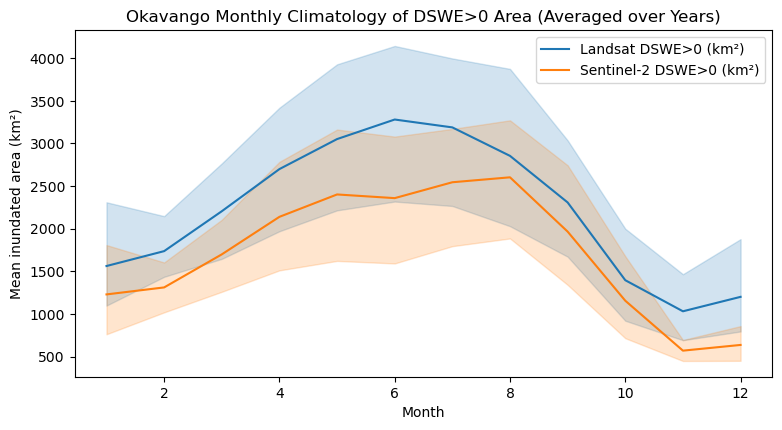

In [186]:
import calendar

import seaborn as sns
import warnings

def monthly_climatology(df: pd.DataFrame, sensor: str) -> pd.Series:
    """
    From a monthly df with columns ['date','count'], compute the mean DSWE>0 area (km²)
    for each calendar month (Jan..Dec) averaged across all years.
    sensor: 'landsat' or 'sentinel' (sentinel is scaled ÷9 to 30 m eq.)
    Returns a Series indexed 1..12 (month) with km² means.
    """
    out = df[['date','count']].copy()
    out['date'] = pd.to_datetime(out['date'], errors='coerce')
    out = out.dropna(subset=['date'])
    if sensor == 'landsat':
        out['km2'] = out['count'] * PX30_TO_KM2
    elif sensor == 'sentinel':
        out['km2'] = (out['count'] / 9.0) * PX30_TO_KM2
    else:
        raise ValueError("sensor must be 'landsat' or 'sentinel'")
    out['month'] = out['date'].dt.month
    out['year'] = out['date'].dt.year    
    # average over all years per calendar month; NaNs are ignored by default
    return out.query('year > 2018')#.groupby('month')['km2'].mean().reindex(range(1,13))

# compute climatologies
ls_clim = monthly_climatology(df_ls, sensor='landsat')
s2_clim = monthly_climatology(df_s2, sensor='sentinel')

# make nice month labels
months = [calendar.month_abbr[m] for m in range(1, 13)]

warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*")
 
# plot (dashed lines with markers)
plt.figure(figsize=(9, 4.5))
sns.lineplot(ls_clim.query("year > 2018 and year != 2021"), x = 'month', y = 'km2',label='Landsat DSWE>0 (km²)')
sns.lineplot(s2_clim.query("year > 2018 and year != 2021").dropna(), x = 'month', y = 'km2',label='Sentinel-2 DSWE>0 (km²)')
plt.xlabel('Month'); plt.ylabel('Mean inundated area (km²)')
plt.title('Okavango Monthly Climatology of DSWE>0 Area (Averaged over Years)')




In [ ]:
# plt.figure(figsize=(9, 4.5))
# for year in range(2019, 2025):
#     sns.lineplot(ls_clim.query("year == {0}".format(year)), x = 'month', c = 'C0', y = 'km2',label='Landsat DSWE>0 (km²)')
#     sns.lineplot(s2_clim.query("year == {0}".format(year)).dropna(), x = 'month', c = 'C1', y = 'km2',label='Sentinel-2 DSWE>0 (km²)')
# plt.xlabel('Month'); plt.ylabel('Mean inundated area (km²)')
# plt.title('Okavango Monthly Climatology of DSWE>0 Area (Averaged over Years)')
# plt.legend().set_visible(False)


Text(0.5, 1.0, 'Monthly inundated area in 2021')

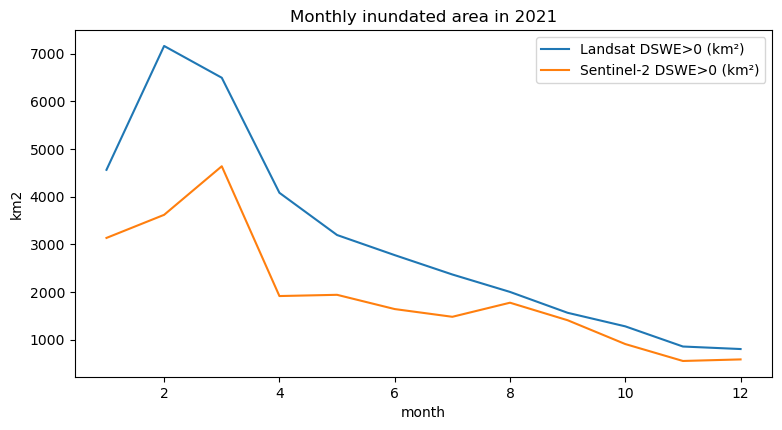

In [139]:
plt.figure(figsize=(9, 4.5))
sns.lineplot(ls_clim.query("year == 2021"), x = 'month', y = 'km2',label='Landsat DSWE>0 (km²)')
sns.lineplot(s2_clim.query("year == 2021").dropna(), x = 'month', y = 'km2',label='Sentinel-2 DSWE>0 (km²)')
plt.title('Monthly inundated area in 2021')

In [140]:

# what happened in 2021
# differenec between years
# seasonal cycle of DSWE == 3... various classes

In [298]:
%%time

def chirps_monthly_by_regions(
    asset_regions: str,
    start: str,
    end: str,
    region_id_prop: str,
    scale_m: int = 5566,   # ~0.05° native CHIRPS
    tilescale: int = 4,
    batch_size: int = 5000,) -> pd.DataFrame:
    """
    Build a monthly CHIRPS rainfall table (mm/month) aggregated by polygons.

    Parameters
    ----------
    asset_regions : str
        GEE FeatureCollection asset path to polygons (e.g., "projects/.../rainfall_regions").
    start, end : str
        Date range; end is exclusive (YYYY-MM-DD).
    region_id_prop : str
        Feature property holding a stable region ID/name.
    scale_m : int
        Reduce scale in meters.
    tilescale : int
        tileScale for reduceRegions (controls server memory/tiling).
    batch_size : int
        Number of features to pull per client-side batch.

    Returns
    -------
    pd.DataFrame with columns: ['region_id','year','month','ym','precip_mm']
    """
    ee.Initialize()

    # Collections
    chirps_daily = (ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
                    .filterDate(start, end))
    regions = ee.FeatureCollection(asset_regions)

    # Tag each daily image with year/month + "YYYY-MM"
    def _tag_month(img):
        d = img.date()
        return img.set({
            "year":  d.get("year"),
            "month": d.get("month"),
            "ym":    d.format("YYYY-MM"),
        })
    tagged = chirps_daily.map(_tag_month)

    # Monthly sum of daily precip (mm/day -> mm/month)
    def _monthly_sum(ym):
        ym = ee.String(ym)
        ic = tagged.filter(ee.Filter.eq("ym", ym))
        summed = (ic.select("precipitation").sum()
                    .rename("precip_mm")
                    .set("ym", ym)
                    .set("year", ee.Number.parse(ym.slice(0,4)))
                    .set("month", ee.Number.parse(ym.slice(5,7))))
        return summed

    unique_yms = tagged.aggregate_array("ym").distinct().sort()
    monthly_ic = ee.ImageCollection(unique_yms.map(_monthly_sum))

    # Zonal stats (mean over polygons). Change Reducer if desired.
    def _reduce_month(img):
        feats = (img.reduceRegions(
                    collection=regions,
                    reducer=ee.Reducer.mean(),
                    scale=scale_m,
                    tileScale=tilescale
                )
                .map(lambda f: f.set({
                    "ym": img.get("ym"),
                    "year": img.get("year"),
                    "month": img.get("month"),
                })))
        return feats

    per_region_fc = monthly_ic.map(_reduce_month).flatten()

    # Pull to client in chunks -> list of dicts
    def _fc_to_rows(fc, n_batch=batch_size):
        n = fc.size().getInfo()
        rows = []
        for start_idx in range(0, n, n_batch):
            sub = (ee.FeatureCollection(fc.toList(n_batch, start_idx))
                   .aggregate_array(".all").getInfo())
            for feat in sub:
                rows.append(feat["properties"])
        return rows

    rows = _fc_to_rows(per_region_fc, n_batch=batch_size)
    if not rows:
        return pd.DataFrame(columns=["region_id","year","month","ym","precip_mm"])

    df = pd.DataFrame(rows)

    # The reducer output column is "<band>_mean" i.e., "precip_mm_mean"
    value_col = "mean" if "mean" in df.columns else None
    if value_col is None:
        # Fallback: find any *_mean column
        mean_cols = [c for c in df.columns if c.endswith("mean")]
        if not mean_cols:
            raise RuntimeError("No reducer result column found (expected 'mean').")
        value_col = mean_cols[0]

    df = (df.rename(columns={value_col: "precip_mm", region_id_prop: "region_id"})
            [["region_id", "year", "month", "ym", "precip_mm"]]
            .sort_values(["region_id", "year", "month"])
            .reset_index(drop=True))

    # Cast types
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].astype(int)
    df["precip_mm"] = pd.to_numeric(df["precip_mm"], errors="coerce")
    df['date'] = pd.to_datetime(df[ ["year", "month"]].assign(day=1))
    return df

chirps_df = chirps_monthly_by_regions(
    asset_regions="projects/ee-okavango/assets/shapes/rainfall_regions",
    start="1990-01-01",
    end="1991-01-01",  # exclusive
    region_id_prop="name",
)
print(df.head())


             region_id  year  month       ym   precip_mm       date
0  east_lower_okavango  2000      1  2000-01  216.591484 2000-01-01
1  east_lower_okavango  2000      2  2000-02  191.254554 2000-02-01
2  east_lower_okavango  2000      3  2000-03   94.204122 2000-03-01
3  east_lower_okavango  2000      4  2000-04   13.349444 2000-04-01
4  east_lower_okavango  2000      5  2000-05    0.008035 2000-05-01
CPU times: user 787 ms, sys: 256 ms, total: 1.04 s
Wall time: 13.4 s


In [299]:
chirps_df.head()

region_id  year  month       ym   precip_mm       date
0  east_lower_okavango  1990      1  1990-01  113.733107 1990-01-01
1  east_lower_okavango  1990      2  1990-02   84.584460 1990-02-01
2  east_lower_okavango  1990      3  1990-03   40.266771 1990-03-01
3  east_lower_okavango  1990      4  1990-04   25.223888 1990-04-01
4  east_lower_okavango  1990      5  1990-05    0.000000 1990-05-01

In [302]:
%%time
import ee
ee.Initialize()

def export_chirps_monthly_by_regions(
    asset_regions: str,
    start: str,
    end: str,
    region_id_prop: str,
    scale_m: int = 5566,      # ~0.05° native CHIRPS
    tilescale: int = 4,
    # ---- export options ----
    to_cloud_storage: bool = False,
    drive_description: str = "chirps_monthly_by_regions",
    drive_filename_prefix: str = "chirps_monthly_by_regions",
    gcs_bucket: str = None,
    gcs_prefix: str = "chirps/monthly_by_regions"
):
    """
    Export monthly CHIRPS rainfall (mm/month) aggregated by polygons as one CSV.
    Columns: ['region_id','ym','year','month','precip_mm']
    """
    chirps_daily = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(start, end)
    regions = ee.FeatureCollection(asset_regions)

    # Tag each daily with YYYY-MM (server-side)
    def _tag_month(img):
        d = img.date()
        return img.set({"ym": d.format("YYYY-MM")})
    tagged = chirps_daily.map(_tag_month)

    # Distinct months (server-side list of strings)
    months = tagged.aggregate_array("ym").distinct().sort()

    # Build per-month FeatureCollection (reduceRegions) and tidy props
    def _month_fc(ym):
        ym = ee.String(ym)
        ic = tagged.filter(ee.Filter.eq("ym", ym))
        img = (ic.select("precipitation").sum()
                 .rename("precip_mm")
                 .set({
                     "ym": ym,
                     "year": ee.Number.parse(ym.slice(0, 4)),
                     "month": ee.Number.parse(ym.slice(5, 7)),
                 }))

        fc = img.reduceRegions(
            collection=regions,
            reducer=ee.Reducer.mean(),
            scale=scale_m,
            tileScale=tilescale
        )

        # Create a NEW geometry-less feature with only desired props
        fc = fc.map(lambda f: ee.Feature(
            None,
            {
                "region_id": f.get(region_id_prop),
                "ym": img.get("ym"),
                "year": img.get("year"),
                "month": img.get("month"),
                "precip_mm": f.get("mean"),
            }
        ))
        return fc

    # months.map(...) -> ee.List of FeatureCollections
    fc_list = months.map(_month_fc)

    # Merge all month FCs into a single FC
    merged = ee.FeatureCollection(
        ee.List(fc_list).iterate(
            lambda fc, acc: ee.FeatureCollection(acc).merge(ee.FeatureCollection(fc)),
            ee.FeatureCollection([])
        )
    )

    selectors = ["region_id","ym","year","month","precip_mm"]

    # Configure and start export
    if to_cloud_storage:
        if not gcs_bucket:
            raise ValueError("Provide gcs_bucket when to_cloud_storage=True.")
        task = ee.batch.Export.table.toCloudStorage(
            collection=merged,
            description=drive_description,
            bucket=gcs_bucket,
            fileNamePrefix=gcs_prefix,
            fileFormat="CSV",
            selectors=selectors
        )
    else:
        task = ee.batch.Export.table.toDrive(
            collection=merged,
            description=drive_description,
            fileNamePrefix=drive_filename_prefix,
            fileFormat="CSV",
            selectors=selectors
        )
    task.start()
    return task

# Example run (Drive):
task = export_chirps_monthly_by_regions(
    asset_regions="projects/ee-okavango/assets/shapes/rainfall_regions",
    start="1990-01-01",
    end="1991-01-01",   # exclusive
    region_id_prop="name",
    scale_m=5566,
    tilescale=4,
    # to_cloud_storage=True, gcs_bucket="okavango-tif", gcs_prefix="chirps/monthly_by_region"
)
print("Started export task:", task.id)


Started export task: NGKCOT4J6UY5MJS2CC5WFYJT
CPU times: user 35.7 ms, sys: 21.7 ms, total: 57.4 ms
Wall time: 779 ms


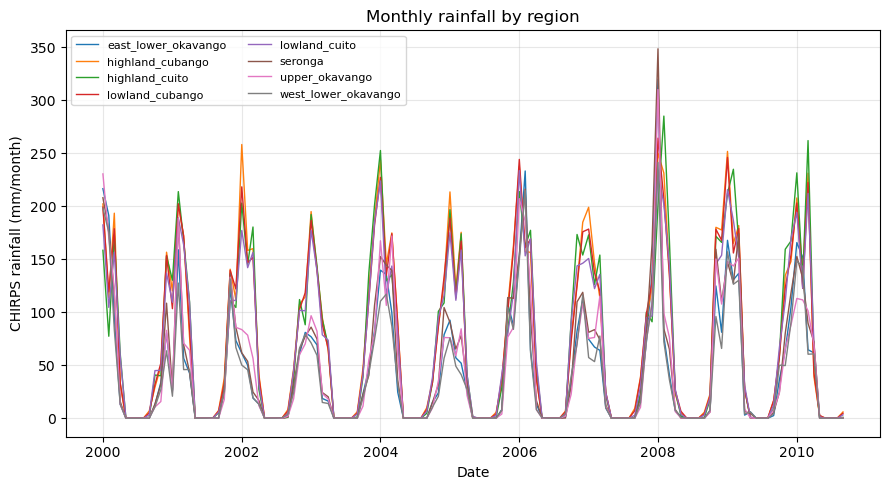

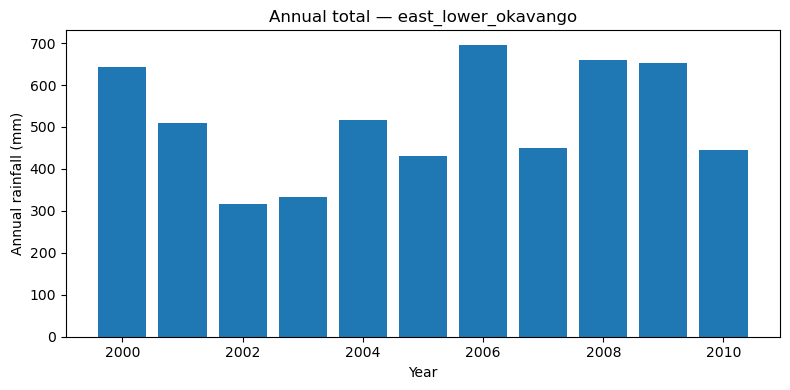

In [288]:

# 1) Multi-region monthly lines
plt.figure(figsize=(9,5))
for rid, sub in df.groupby("region_id"):
    plt.plot(sub["date"], sub["precip_mm"], label=rid, linewidth=1)
plt.xlabel("Date"); plt.ylabel("CHIRPS rainfall (mm/month)")
plt.title("Monthly rainfall by region")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# 2) Annual totals (per region) as bars
annual = (df.assign(year=df["date"].dt.year)
            .groupby(["region_id","year"], as_index=False)["precip_mm"].sum())
# Pick one region to visualize (or loop)
one = annual[annual["region_id"] == annual["region_id"].iloc[0]]
plt.figure(figsize=(8,4))
plt.bar(one["year"], one["precip_mm"])
plt.xlabel("Year"); plt.ylabel("Annual rainfall (mm)")
plt.title(f"Annual total — {one['region_id'].iloc[0]}")
plt.tight_layout()
plt.show()

In [153]:
import ee
import geemap.foliumap as geemap  # <-- folium backend (no jupyter-leaflet)
ee.Initialize()

year = '2019'


# helpers/vis
def dswe_jas_mean(ic, y):
    img = (ic.filter(ee.Filter.eq('year', y))
             .filter(ee.Filter.gte('month','07'))
             .filter(ee.Filter.lte('month','09'))
             .select(0)
             .mean().gt(0))
    return img.updateMask(img.gt(0))

vis_dswe_classes = {"palette": ['white','#deebf7','#9ecae1','#3182bd'], "min": 1, "max": 4}
vis_dswe_bin = {"palette": ['#9ecae1'], "min": 1, "max": 1}
vis_il = {"min": 0, "max": 1, "palette": ['#3182bd']}

# build images
il_year = IL_merged.filter(ee.Filter.eq('year', year)).mean().select(0)
il_year = il_year.updateMask(il_year.eq(1))
s2_jas  = dswe_jas_mean(s2_dswe, year)
ls_jas  = dswe_jas_mean(ls_dswe_collection,    year)

# folium map
m = geemap.Map()  # folium map
m.add_basemap('HYBRID')
m.addLayer(il_year, vis_il,               f'IL {year}')
m.addLayer(ls_jas,  vis_dswe_bin,     f'Landsat DSWE JAS {year}')


# Ensure binary masks (should already be 1/0 from your prep, but guard anyway)
il_bin  = il_year.gt(0)
dswe_bin = ls_jas.gt(0)

both     = il_bin.And(dswe_bin)
il_only  = il_bin.And(dswe_bin.eq(0))
dswe_only= dswe_bin.And(il_bin.eq(0))

compare = (
    both.multiply(2)
        .add(il_only.multiply(1))
        .add(dswe_only.multiply(3))
        .selfMask()  # hide 0 = neither
)

compare_vis = {
    "min": 1, "max": 3,
    "palette": [
        "#9ecae1",  # 1: IL=1, DSWE=0 (light blue)
        "#08519c",  # 2: Both=1 (dark blue)
        "#ffd92f"   # 3: IL=0, DSWE=1 (yellow)
    ]
}

m.addLayer(compare.clip(okavango), compare_vis, f"IL vs Landsat DSWE (JAS {year})", True)


m.addLayer(s2_jas,  vis_dswe_bin,     f'Sentinel-2 DSWE JAS {year}')
m.centerObject(okavango, 8)
m


In [269]:
year = '2019'
month = '02'

vis_dswe_classes = {"palette": ['white','#deebf7','#9ecae1','#3182bd'], "min": 1, "max": 4}
vis_dswe_bin = {"palette": ['#9ecae1'], "min": 1, "max": 1}
vis_il = {"min": 0, "max": 1, "palette": ['#3182bd']}

s2_month  = s2_dswe.filter(ee.Filter.eq('month', month)).filter(ee.Filter.eq('year', year))
ls_month  = ls_dswe_collection.filter(ee.Filter.eq('month', month)).filter(ee.Filter.eq('year', year))

# folium map
m = geemap.Map()  # folium map
m.add_basemap('HYBRID')
m.addLayer(s2_month.first().select('DSWE').selfMask(), vis_dswe_classes,  f'Sentinel {year}-{month}')
m.addLayer(ls_month.first().select('dswe').selfMask(),  vis_dswe_classes, f'Landsat {year}-{month}')

m.centerObject(okavango, 8)
m

In [183]:
year_start = 1991
year_end   = 2019   # inclusive


vis_frac = {  # sequential 0..1
    "min": 0, "max": 1,
    "palette": ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']
}
vis_diff_rwb = {"min": -1, "max": 1, "palette": ['#ef8a62','#f7f7f7','#67a9cf']}

def years_list(y0, y1):
    return ee.List.sequence(y0, y1).map(lambda y: ee.String(ee.Number(y).format('%d')))

def landsat_wet_valid_for_year(ic, y_str):
    """Return 2-band image for a year: wet(0/1), valid(0/1) for JAS DSWE; fully masked if no data."""
    sub = (ic.filter(ee.Filter.eq('year', y_str))
             .filter(ee.Filter.gte('month', '07'))
             .filter(ee.Filter.lte('month', '09')))
    size = sub.size()

    # compute when we DO have images
    img   = sub.select('dswe').mean()                          # may be 0-band if size==0
    wet   = img.gt(0).rename('wet')
    valid = img.mask().gt(0).rename('valid')
    out   = wet.updateMask(valid).addBands(valid.updateMask(valid))

    # fallback: return fully masked 2-band image (wet, valid)
    empty = ee.Image.constant([0,0]).rename(['wet','valid']).updateMask(ee.Image(0))

    return ee.Image(ee.Algorithms.If(size.gt(0), out, empty))

def il_wet_valid(img):
    """IL codes: 0=dry, 1/2=wet, 3=nodata -> wet + valid bands."""
    il    = img.select(0).rename('il_raw')
    wet   = il.eq(1).rename('wet')
    valid = il.neq(3).rename('valid')
    wet   = wet.updateMask(valid)
    valid = valid.updateMask(valid)
    
    return wet.addBands(valid).copyProperties(img, ['year'])

# ---------- IL fraction-of-years ----------
ys = years_list(year_start, year_end)

il_range = (IL_merged
            .filter(ee.Filter.gte('year', ee.String(str(year_start))))
            .filter(ee.Filter.lte('year', ee.String(str(year_end))))
            .map(il_wet_valid))

il_wet_sum   = il_range.select('wet').sum()
il_valid_sum = il_range.select('valid').sum()
il_frac      = il_wet_sum.divide(il_valid_sum).rename('il_frac')

# ---------- Landsat fraction-of-years (JAS) ----------
def ls_year_img(y_str):
    return landsat_wet_valid_for_year(ls_dswe_collection, y_str)

ls_range     = ee.ImageCollection(ys.map(lambda y: ls_year_img(ee.String(y))))
ls_wet_sum   = ls_range.select('wet').sum()
ls_valid_sum = ls_range.select('valid').sum()
ls_frac      = ls_wet_sum.divide(ls_valid_sum).rename('ls_frac')



m = geemap.Map()
m.add_basemap('HYBRID')

m.addLayer(il_frac.selfMask().clip(okavango), vis_frac, f'IL fraction wet {year_start}-{year_end}')
m.addLayer(ls_frac.selfMask().clip(okavango), vis_frac, f'Landsat DSWE fraction wet (JAS) {year_start}-{year_end}')

# ---------- Difference ----------
diff_frac = ls_frac.unmask().subtract(il_frac.unmask()).rename('diff_frac')
m.addLayer(diff_frac.updateMask(diff_frac.neq(0)).clip(okavango), vis_diff_rwb, 'Landsat − IL (fraction)')

m.centerObject(okavango, 8)
m


In [266]:
import geemap.foliumap as geemap
import folium

m = geemap.Map()
m.add_basemap('HYBRID')

# Example: add layers clipped to the shapefile boundary
m.addLayer(il_frac.clip(okavango).selfMask(), vis_frac, 'IL fraction inundated')
m.addLayer(ls_frac.updateMask(ls_frac.gte(0.1)).clip(okavango), vis_frac, 'Landsat DSWE fraction wet (JAS)')

# ---------- Difference ----------
diff_frac = ls_frac.unmask().subtract(il_frac.unmask()).rename('diff_frac')
m.addLayer(diff_frac.updateMask(diff_frac.neq(0)).clip(okavango), vis_diff_rwb, 'Landsat − IL (fraction)')


# --- Styled gradient legend (white text, larger font) ---
palette = vis_frac['palette']
vmin = vis_frac.get('min', 0)
vmax = vis_frac.get('max', 1)
label = 'Fraction years wet (0–1)'

# Build CSS gradient stops
stops = ','.join([f'{c} {int(i*100/(len(palette)-1))}%' for i, c in enumerate(palette)])

ticks = [vmin, vmin + (vmax-vmin)*0.25, vmin + (vmax-vmin)*0.5, vmin + (vmax-vmin)*0.75, vmax]
tick_html = ''.join(f'<span>{t:.1f}</span>' for t in ticks)


legend_html = f"""
<div style="
  position: fixed;
  bottom: 20px; right: 20px;
  z-index: 9999;
  background: rgba(0,0,0,0.45);
  padding: 12px 14px;
  border-radius: 12px;
  color: white;                 /* white font */
  font-size: 16px;              /* larger font */
  line-height: 1.2;
  min-width: 320px;">
  <div style="margin-bottom:10px; font-weight:600;">{label}</div>
  <div style="display:flex; flex-direction:column; gap:8px;">
    <div style="
      width: 320px; height: 16px;
      background: linear-gradient(to right, {stops});
      border-radius: 6px;"></div>
    <div style="display:flex; justify-content:space-between;">
      {tick_html}
    </div>
  </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Controls + view
m.add_layer_control()
m.centerObject(okavango, 8)
m


In [268]:
# ---- params ----
year_start = 1991
year_end   = 2019   # inclusive

# ---- viz ----
vis_months = {  # mean # of wet months in JAS (0..3)
    "min": 0, "max": 12,
    "palette": ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
}

def years_list(y0, y1):
    return ee.List.sequence(y0, y1).map(lambda y: ee.String(ee.Number(y).format('%d')))

DSWE_BAND = ee.String(ls_dswe_collection.first().bandNames().get(0)) 

def landsat_month_wet_or_mask(ic, year_str, month_str):
    """
    Return single-band 'wet' for (year, month):
      wet = 1 where monthly mean DSWE > 0; masked where that month has no valid data.
    Robust to string/number props and band name differences.
    """
    y_num = ee.Number.parse(year_str)
    m_num = ee.Number.parse(month_str)

    f_year  = ee.Filter.Or(ee.Filter.eq('year', year_str),  ee.Filter.eq('year', y_num))
    f_month = ee.Filter.Or(ee.Filter.eq('month', month_str), ee.Filter.eq('month', m_num))

    sub = ic.filter(f_year).filter(f_month)
    size = sub.size()

    mean_dswe = sub.select([DSWE_BAND]).mean()  # monthly mean
    wet   = mean_dswe.gt(0).rename('wet')
    valid = mean_dswe.mask().gt(0)
    wet   = wet.updateMask(valid)               # mask where that month has no data

    empty = ee.Image.constant(0).rename('wet').updateMask(ee.Image(0))  # fully masked if month empty
    return ee.Image(ee.Algorithms.If(size.gt(0), wet, empty))

def landsat_wet_months_for_year(ic, year_str):
    """Sum wet months for Jan..Dec (0..12); unmask to 0 so yearly images always have a value."""
    months = ee.List.sequence(1, 12).map(lambda m: ee.String(ee.Number(m).format('%02d')))
    ic12 = ee.ImageCollection(months.map(lambda m: landsat_month_wet_or_mask(ic, year_str, ee.String(m))))
    return ic12.sum().rename('wet_months').unmask()  # << key


# ---- build Landsat: mean # wet months across years  ----
ys = years_list(year_start, year_end)
ls_yearly_wetmonths = ee.ImageCollection(ys.map(lambda y: landsat_wet_months_for_year(ls_dswe_collection, ee.String(y))))

# Average across years; pixels with no valid JAS months in a year are masked that year (excluded from mean)
ls_mean_months = ls_yearly_wetmonths.limit(3).mean().rename('ls_mean_wet_months') 


import folium

# --- Horizontal gradient legend for "wet months" (0–12) ---
palette = vis_months['palette']
vmin = vis_months.get('min', 0)
vmax = vis_months.get('max', 12)
label = 'Wet months per year'

# Build CSS gradient stops left→right
stops = ','.join([f'{c} {int(i*100/(len(palette)-1))}%' for i, c in enumerate(palette)])

# Choose evenly spaced tick labels (0, 3, 6, 9, 12)
ticks = [vmin, vmin + (vmax-vmin)*0.25, vmin + (vmax-vmin)*0.5, vmin + (vmax-vmin)*0.75, vmax]
tick_html = ''.join(f'<span>{t:.0f}</span>' for t in ticks)

legend_html = f"""
<div style="
  position: fixed;
  bottom: 20px; right: 20px;
  z-index: 9999;
  background: rgba(0,0,0,0.45);
  padding: 12px 14px;
  border-radius: 12px;
  color: white;                 /* white font */
  font-size: 16px;              /* larger font */
  line-height: 1.2;
  min-width: 320px;">
  <div style="margin-bottom:10px; font-weight:600;">{label}</div>
  <div style="display:flex; flex-direction:column; gap:8px;">
    <div style="
      width: 320px; height: 16px;
      background: linear-gradient(to right, {stops});
      border-radius: 6px;"></div>
    <div style="display:flex; justify-content:space-between;">
      {tick_html}
    </div>
  </div>
</div>
"""

m = geemap.Map()
m.add_basemap('HYBRID')

ls_mean_months

m.addLayer(ls_mean_months.clip(okavango), 
           vis_months,
           f'Landsat DSWE: mean # wet months ({year_start}-{year_end})')

m.addLayer(ls_yearly_wetmonths.first().clip(okavango).selfMask(), 
           vis_months,
           f'Landsat DSWE: mean # wet months ')
m.get_root().html.add_child(folium.Element(legend_html))

m.centerObject(okavango, 8)
m


In [177]:
label

'Fraction years wet (0–1)'

In [283]:
 ls_dswe_collection

In [148]:
    
# var highlands = ee.FeatureCollection(
#   "projects/ee-okavango/assets/shapes/1274m_contour")
# var regions = ee.FeatureCollection(
#   "projects/ee-okavango/assets/shapes/rainfall_regions")

In [150]:
# # --- Monthly Sentinel-2 & Landsat 8/9 visualization (Earth Engine + geemap) ---

from datetime import date, timedelta
from calendar import monthrange


# ---------- Helpers ----------
def _month_start_end(year: int, month: int):
    start = date(year, month, 1)
    end = date(year, month, monthrange(year, month)[1]) + timedelta(days=1)
    return start.isoformat(), end.isoformat()

def _mask_s2_clouds(img: ee.Image) -> ee.Image:
    # QA60 bits: 10 = opaque cloud, 11 = cirrus
    qa = img.select('QA60')
    mask = qa.bitwiseAnd((1 << 10) | (1 << 11)).eq(0)
    return img.updateMask(mask)

def _scale_s2(img: ee.Image) -> ee.Image:
    # S2 SR is scaled by 10000 in EE catalog
    optical = img.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']).divide(10000)
    return img.addBands(optical, overwrite=True)

def _mask_ls_l2(img: ee.Image) -> ee.Image:
    qa = img.select('QA_PIXEL')
    # Require no dilated cloud (bit1), cirrus (bit2), cloud (bit3), or cloud shadow (bit4)
    cloudy_bits = (1 << 1) | (1 << 2) | (1 << 3) | (1 << 4)
    clear = qa.bitwiseAnd(cloudy_bits).eq(0)
    # Optionally drop saturated pixels (any band saturated -> bit set in QA_RADSAT)
    radsat_ok = img.select('QA_RADSAT').eq(0)
    return img.updateMask(clear).updateMask(radsat_ok)

def _scale_ls_l2(img: ee.Image) -> ee.Image:
    # Landsat C2 L2 reflectance scaling: value * 2.75e-05 + (-0.2)
    sr = (img.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'])
            .multiply(2.75e-05).add(-0.2))
    return img.addBands(sr, overwrite=True)

def monthly_composites(year: int, month: int, roi: ee.Geometry, s2_cloud_pct: int = 80):
    start, end = _month_start_end(year, month)

    # Sentinel-2 SR (harmonized)
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate(start, end)
          .filterBounds(roi)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', s2_cloud_pct))
          .map(_mask_s2_clouds)
          .map(_scale_s2))
    s2_med = s2.median().clip(roi)
    s2_mndwi = s2_med.normalizedDifference(['B3', 'B11']).rename('mndwi')

    # Landsat 8/9 L2 SR (Tier 1)
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    ls = (l8.merge(l9)
            .filterDate(start, end)
            .filterBounds(roi)
            .map(_mask_ls_l2)
            .map(_scale_ls_l2))
    ls_med = ls.median().clip(roi)
    ls_mndwi = ls_med.normalizedDifference(['SR_B3', 'SR_B6']).rename('mndwi')

    return dict(
        s2_rgb=s2_med,
        s2_mndwi=s2_mndwi,
        ls_rgb=ls_med,
        ls_mndwi=ls_mndwi
    )

def visualize_month(year: int, month: int, roi: ee.Geometry, zoom: int = 7):
    comps = monthly_composites(year, month, roi)
    yyyymm = f"{year}-{month:02d}"

    m = geemap.Map()
    m.centerObject(roi, zoom)

    # True color
    m.addLayer(
        comps['s2_rgb'],
        {'bands': ['B4','B3','B2'], 'min': 0.02, 'max': 0.30},
        f'Sentinel-2 RGB {yyyymm}'
    )
    m.addLayer(
        comps['ls_rgb'],
        {'bands': ['SR_B4','SR_B3','SR_B2'], 'min': 0.02, 'max': 0.30},
        f'Landsat 8/9 RGB {yyyymm}'
    )

    # Water highlight (mNDWI)
    m.addLayer(
        comps['s2_mndwi'],
        {'min': -0.5, 'max': 1.0, 'palette': ['8c510a','d8b365','5ab4ac']},
        f'Sentinel-2 mNDWI {yyyymm}',
        False
    )
    m.addLayer(
        comps['ls_mndwi'],
        {'min': -0.5, 'max': 1.0, 'palette': ['8c510a','d8b365','5ab4ac']},
        f'Landsat 8/9 mNDWI {yyyymm}',
        False
    )

    # ROI overlay (toggleable)
    try:
        m.addLayer(roi, {}, 'ROI', False)
    except Exception:
        pass

    return m


# ---------- Example call ----------
# Change year/month as needed; this will display an interactive map.
m = visualize_month(2023, 6, okavango, zoom=7)
m
